In [201]:
import json
import os
import sys
import time
import warnings
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx 
import pyranges as pr
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

sys.path.insert(0,'/Users/k2585057/borzoi/')
from examples.borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

bz_path = '/Users/k2585057/borzoi/'
gn_path = '/Users/k2585057/Dropbox/PhD/Analysis/Project/GENOME/'

In [2]:
import platform
platform.platform()

'macOS-15.6.1-arm64-arm-64bit'

In [3]:
import os
os.uname()

posix.uname_result(sysname='Darwin', nodename='KCLMRYM6JWW4M', release='24.6.0', version='Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:40 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6041', machine='arm64')

In [3]:
import os
os.uname()

posix.uname_result(sysname='Darwin', nodename='KCLMRYM6JWW4M', release='24.6.0', version='Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:40 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6041', machine='arm64')

# Load in model

In [199]:
start, 166175000

(165797856, 166175000)

In [7]:
def mutate(wt_code, poses, start, alts):
    #Induce mutation(s)
    mut_code = np.copy(wt_code)
    for pos, alt in zip(poses, alts) :
        alt_ix = -1
        if alt == 'A' :
            alt_ix = 0
        elif alt == 'C' :
            alt_ix = 1
        elif alt == 'G' :
            alt_ix = 2
        elif alt == 'T' :
            alt_ix = 3
    
        mut_code[pos-start-1] = 0.
        mut_code[pos-start-1, alt_ix] = 1.
    return(mut_code)


def expression(y_wt, y_mut):
    start_trim = 169000 // 32                      # 5281
    end_trim   = (166175000 - start) // 32         # 11785
    brain_tracks = [17, 18, 19]
    wt_sum  = tf.reduce_sum(y_wt[:, :, start_trim:end_trim, brain_tracks])
    mut_sum = tf.reduce_sum(y_mut[:, :, start_trim:end_trim, brain_tracks])
    return(wt_sum, mut_sum)
    #sum over tissue

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_brain_tracks(y_wt_list, y_mut_list, start,
                      brain_tracks=(17, 18, 19),
                      bp_per_bin=32,
                      start_bp=169000,
                      end_bp_abs=166175000,
                      window_name="Promoter"):
    """
    Plot mean±SEM of predicted brain-track expression across the genomic window,
    comparing WT vs Mutant across model folds, plus residual (Mut-WT).

    Parameters
    ----------
    y_wt_list, y_mut_list : list of tensors/arrays
        Each element shape ~ [1, 1, positions, tracks]
    start : int
        Genomic start coordinate used to build the input window.
    brain_tracks : tuple/list of int
        Track indices to aggregate (e.g., brain-related tracks).
    bp_per_bin : int
        Genomic bases represented by one output bin (typically 32).
    start_bp : int
        Left boundary (in bp) of the evaluation window relative to 'start'.
    end_bp_abs : int
        Absolute genomic coordinate of the right boundary (in bp).
    window_name : str
        Title label.

    Returns
    -------
    None (plots figure)
    """

    # Compute bin indices for the evaluation window
    start_trim = start_bp // bp_per_bin
    end_trim   = (end_bp_abs - start) // bp_per_bin  # assumes 'start' is absolute

    def _to_np(y):
        return y.numpy() if isinstance(y, tf.Tensor) else y

    def _extract_positions_mean(y):
        """
        Returns a vector (length L) of mean signal across selected tracks at each position.
        """
        arr = _to_np(y)
        # Slice positions window: keep tracks axis as the last axis
        # Expected arr shape: [1, 1, positions, tracks]
        arr = arr[0, 0, start_trim:end_trim, :]  # shape (L, tracks)
        # Select tracks while preserving axis order
        arr = np.take(arr, indices=brain_tracks, axis=-1)  # shape (L, len(tracks))
        # Mean across tracks -> shape (L,)
        return arr.mean(axis=-1)

    # Stack folds: shape (n_folds, L)
    wt_mat  = np.stack([_extract_positions_mean(y) for y in y_wt_list], axis=0)
    mut_mat = np.stack([_extract_positions_mean(y) for y in y_mut_list], axis=0)

    # Mean and SEM across folds
    wt_mean, mut_mean = wt_mat.mean(axis=0), mut_mat.mean(axis=0)
    wt_sem  = wt_mat.std(axis=0, ddof=1) / np.sqrt(wt_mat.shape[0]) if wt_mat.shape[0] > 1 else np.zeros_like(wt_mean)
    mut_sem = mut_mat.std(axis=0, ddof=1) / np.sqrt(mut_mat.shape[0]) if mut_mat.shape[0] > 1 else np.zeros_like(mut_mean)

    residual_mean = mut_mean - wt_mean

    # X-axis in bins (each ~32bp). If you prefer bp coordinates, uncomment the bp line.
    x_bins = np.arange(start_trim, end_trim)
    # x_bp = start + x_bins * bp_per_bin  # absolute genomic bp

    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Top: WT vs Mutant with SEM bands
    ax1.plot(x_bins, wt_mean, label='WT', c = 'k')
    ax1.fill_between(x_bins, wt_mean - wt_sem, wt_mean + wt_sem, alpha=0.3)
    ax1.plot(x_bins, mut_mean, label='Mutant', c='crimson', alpha=0.4)
    ax1.fill_between(x_bins, mut_mean - mut_sem, mut_mean + mut_sem, alpha=0.3)
    ax1.set_ylabel('Predicted brain expression')
    ax1.set_title(f"{window_name} — mean ± SEM over {wt_mat.shape[0]} folds")
    ax1.legend()

    # Bottom: Residual
    ax2.plot(x_bins, residual_mean)
    ax2.axhline(0, linestyle='--', linewidth=2)
    ax2.set_ylabel('Residual\n(Mut - WT)')
    ax2.set_xlabel('Output bin ({} bp/bin)'.format(bp_per_bin))

    plt.tight_layout()
    plt.show()

In [63]:
#load annotations
#===================================
#Initialize fasta sequence extractor 
fasta_open = pysam.Fastafile(f'{gn_path}/annotations/hg38/assembly/ucsc/hg38.fa')
#Load GTF (optional; needed to compute exon coverage attributions for example gene)
transcriptome = bgene.Transcriptome(f'{gn_path}/annotations/hg38/genes/gencode41/gencode41_basic_nort.gtf')

#Model configuration
#=============================
params_file = f'{bz_path}/examples/params_pred.json'
targets_file = f'{bz_path}/examples/targets_gtex.txt' #Subset of targets_human.txt
seq_len = 524288
rc = True         #Average across reverse-complement prediction
n_folds = 4       #To use only one model fold, set to 'n_folds = 1'. To use all four folds, set 'n_folds = 4'.

search_gene = 'ENSG00000144285.23' #SCN1A
center_pos = 166_060_000
chrom = 'chr2'
start = center_pos - seq_len // 2
end = center_pos + seq_len // 2
print(start,end)

#SCN1A promoter positions
#=============================
# P1a= [166148180, 166151550]
# P1b= [166127360, 166129030]
# P1c= [166077140, 166079490]
# scn1a = [165984641, 166182806]

165797856 166322144


In [64]:
#================================
#load model params 
#===================================

#Read model parameters
with open(params_file) as params_open:
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']


#Read targets
targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index
assert all(targets_df['strand_pair'].values == targets_df.index), 'strand pairs dont match indeces - may causes errors later'

#Create local index of strand_pair (relative to sliced targets)
#THIS SEEMS WEIRD - MAYBE FIX LATER!
if rc :
    strand_pair = targets_df.strand_pair 
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble
#==========================
models = []
for fold_ix in range(n_folds) :
    model_file = f'/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/saved_models/f3c{str(fold_ix)}/train/model0_best.h5'
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    models.append(seqnn_model)

# Visualise sequence change

In [65]:
#Define start and end indeces for expression estimation
start_trim = 169000 // 32
end_trim = (166175000 - start) // 32
start_trim, end_trim
# y_mut = predict_tracks(models, new_one_hot)
# brain_mut = 100000 * y_mut[:, :, start_trim:end_trim, 17:20] #17, 18, 19 are the brain tracks
# mut_sum = int(tf.reduce_sum(brain_mut))/100000

(5281, 11785)

In [83]:
models*4

In [103]:
np.concatenate((['A']*4, ['B1']*4, ['B2']*4))

array(['A', 'A', 'A', 'A', 'B1', 'B1', 'B1', 'B1', 'B2', 'B2', 'B2', 'B2'],
      dtype='<U2')

In [130]:
from tqdm import tqdm
import tensorflow as tf
import pandas as pd

# --- Load variant table ---
name_l, fold_l, exp_l, m_l = [],[],[],[]
df = pd.read_excel('/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/oscars_top3.xlsx')

#select sequence
#=================

prom_l = np.concatenate((['A']*4, ['B1']*4, ['B2']*4))
model_l = models*3
#predict
for x,model in enumerate(tqdm(model_l)):
    prom = prom_l[x]
    curr_df = df[(df['Name'] == prom)  & (df['Use']=='Y')].set_index('Position')
    alts  = curr_df['Mutation'].tolist()
    poses = curr_df.index.tolist()
    #mutate
    wt_code  = process_sequence(fasta_open, chrom, start, end)
    mut_code = mutate(wt_code, poses, start, alts)
    #predict
    y_wt  = predict_tracks([model], wt_code)
    y_mut = predict_tracks([model], mut_code)
    #quantify
    wt_sum, mut_sum = expression(y_wt, y_mut)
    
    fold_l.append(float(mut_sum / wt_sum))
    name_l.append(prom)
    exp_l.append((float(wt_sum), float(mut_sum)))
    m_l.append(x%4)

df = pd.DataFrame({'foldchange': fold_l, 'promoter':name_l, 'exp': exp_l, 'fold': m_l})
exp = np.ravel([np.array(i) for i in df['exp'].values])
df = df.loc[df.index.repeat(2)].reset_index().drop(columns=['index', 'exp'])
df['exp'] =  exp
df['type'] = np.tile(['wt','mut'], len(df)//2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [10:06<00:00, 50.50s/it]


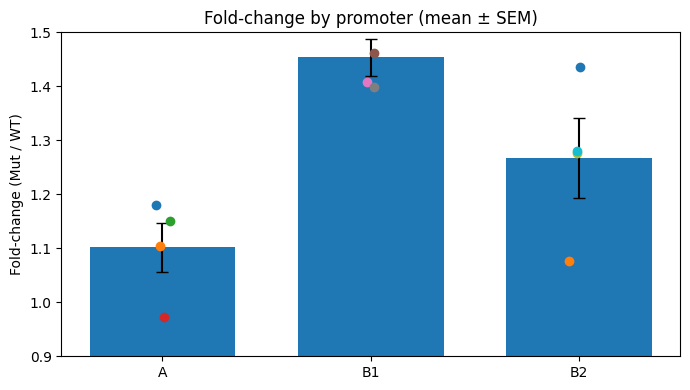

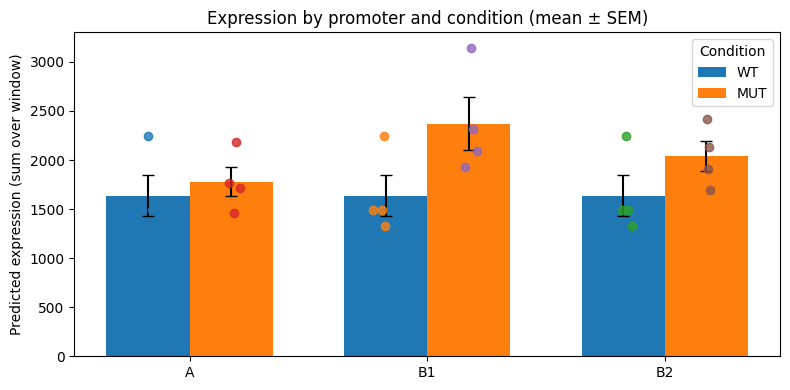

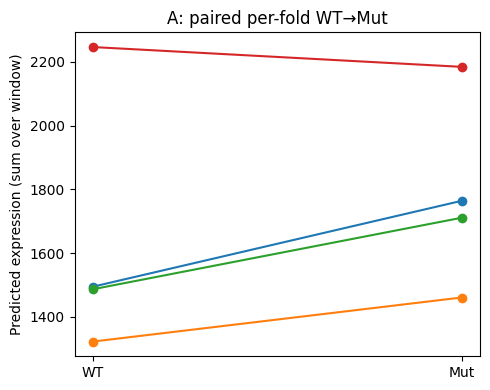

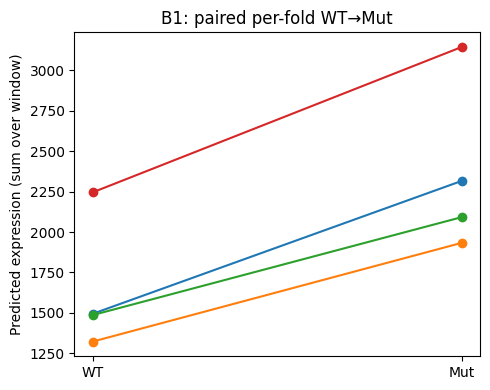

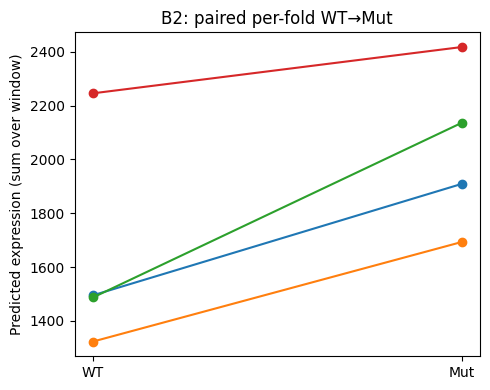

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Ensure dtypes are right ---
df['promoter'] = df['promoter'].astype(str)
df['type']     = df['type'].astype(str)
df['fold']     = df['fold'].astype(int)
df['foldchange'] = df['foldchange'].astype(float)
df['exp']        = df['exp'].astype(float)

# ========== 1) Fold-change per promoter: mean ± SEM + points ==========
fc_sum = (
    df[['promoter', 'fold', 'foldchange']]
    .drop_duplicates(['promoter','fold'])   # avoid double counting wt/mut rows
    .groupby('promoter', as_index=False)
    .agg(mean=('foldchange','mean'),
         std=('foldchange','std'),
         n=('foldchange','count'))
)
fc_sum['sem'] = fc_sum['std'] / np.sqrt(fc_sum['n'].clip(lower=1))

fig = plt.figure(figsize=(7,4))
x = np.arange(len(fc_sum))
width = 0.7

plt.bar(x, fc_sum['mean'].values, width=width, yerr=fc_sum['sem'].values, capsize=4)
plt.ylim(0.9,1.6)
plt.xticks(x, fc_sum['promoter'].values)
plt.ylabel('Fold-change (Mut / WT)')
plt.title('Fold-change by promoter (mean ± SEM)')

# Overlay individual fold-change points with small jitter
fc_points = (
    df[['promoter','fold','foldchange']]
    .drop_duplicates(['promoter','fold'])
    .sort_values(['promoter','fold'])
)
prom_to_x = {p:i for i,p in enumerate(fc_sum['promoter'])}
rng = np.random.default_rng(123)
for _, row in fc_points.iterrows():
    jitter = rng.normal(0, 0.03)
    plt.plot(prom_to_x[row['promoter']] + jitter, row['foldchange'], marker='o', linestyle='')

plt.tight_layout()

# ========== 2) Expression grouped (WT vs Mut) per promoter: mean ± SEM + points ==========
exp_sum = (
    df.groupby(['promoter','type'], as_index=False)
      .agg(mean=('exp','mean'),
           std=('exp','std'),
           n=('exp','count'))
)
exp_sum['sem'] = exp_sum['std'] / np.sqrt(exp_sum['n'].clip(lower=1))

promoters = exp_sum['promoter'].unique().tolist()
types = ['wt','mut']
x = np.arange(len(promoters))
width = 0.35

fig = plt.figure(figsize=(8,4))
for i, t in enumerate(types):
    sub = exp_sum[exp_sum['type']==t].set_index('promoter').reindex(promoters)
    centers = x + (i - 0.5)*(width)
    plt.bar(centers, sub['mean'].values, width=width, yerr=sub['sem'].values, capsize=4, label=t.upper())
    

# Overlay individual points (from each fold)
rng = np.random.default_rng(456)
for i, t in enumerate(types):
    centers = x + (i - 0.5)*(width)
    for j, p in enumerate(promoters):
        pts = df[(df['promoter']==p) & (df['type']==t)]['exp'].values
        if pts.size:
            jitter = rng.normal(0, 0.02, size=pts.size)
            plt.plot(np.full(pts.size, centers[j]) + jitter, pts, marker='o', linestyle='', alpha=0.8)

plt.xticks(x, promoters)
plt.ylabel('Predicted expression (sum over window)')
plt.title('Expression by promoter and condition (mean ± SEM)')
plt.legend(title='Condition')
plt.tight_layout()

# ========== 3) Paired WT↔Mut per fold (one chart per promoter) ==========
# Lines connecting WT→Mut for each fold, useful to see per-fold changes.
for p in promoters:
    piv = (df[df['promoter']==p]
           .pivot(index='fold', columns='type', values='exp')
           .sort_index())
    if {'wt','mut'}.issubset(piv.columns):
        fig = plt.figure(figsize=(5,4))
        x_pts = [0, 1]  # 0=WT, 1=Mut
        for fold_idx, row in piv.iterrows():
            plt.plot(x_pts, [row['wt'], row['mut']], marker='o', linestyle='-')
        plt.xticks(x_pts, ['WT','Mut'])
        plt.ylabel('Predicted expression (sum over window)')
        plt.title(f'{p}: paired per-fold WT→Mut')
        plt.tight_layout()


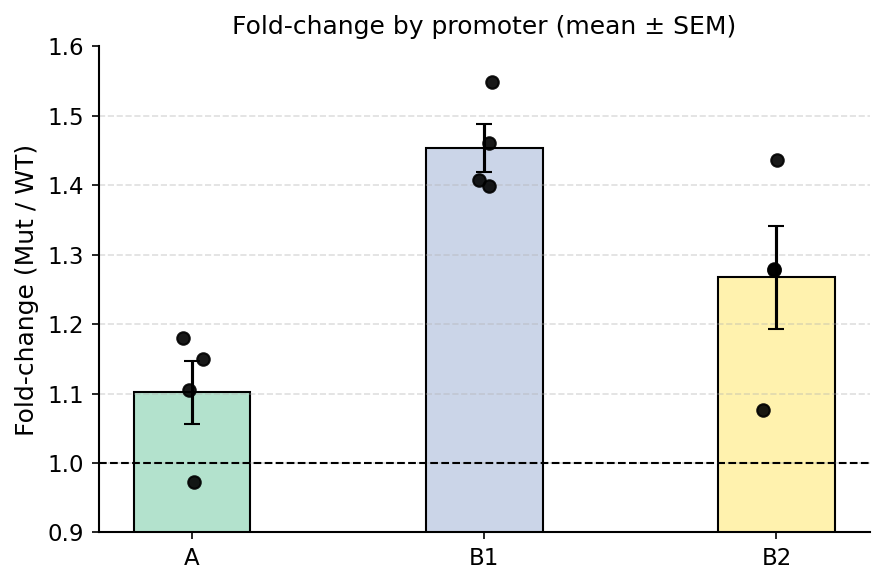

In [194]:
import numpy as np
import matplotlib.pyplot as plt

# --- Make sure numeric types are correct ---
df['promoter'] = df['promoter'].astype(str)
df['foldchange'] = df['foldchange'].astype(float)
df['fold'] = df['fold'].astype(int)

# --- Compute mean ± SEM per promoter ---
fc_sum = (
    df[['promoter', 'fold', 'foldchange']]
    .drop_duplicates(['promoter', 'fold'])
    .groupby('promoter', as_index=False)
    .agg(mean=('foldchange', 'mean'),
         std=('foldchange', 'std'),
         n=('foldchange', 'count'))
)
fc_sum['sem'] = fc_sum['std'] / np.sqrt(fc_sum['n'].clip(lower=1))

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))

x = np.arange(len(fc_sum))
width = 0.4

# sample different colors from a pastel colormap
cmap = plt.get_cmap('Pastel2')
colors = [cmap(i / len(fc_sum)) for i in range(len(fc_sum))]

bars = ax.bar(
    x, fc_sum['mean'], width=width,
    yerr=fc_sum['sem'], capsize=4,
    color=colors, alpha=1, edgecolor='black'
)
plt.axhline(1, linewidth=1, linestyle='--', c = 'k')

# Overlay individual fold-change points with small jitter
rng = np.random.default_rng(123)
for i, p in enumerate(fc_sum['promoter']):
    pts = df.loc[df['promoter']==p, 'foldchange'].unique()
    jitter = rng.normal(0, 0.03, size=len(pts))
    ax.plot(np.full_like(pts, x[i]) + jitter, pts,
            'o', color='black', markersize=6, alpha=0.9, zorder=3)

# Style
ax.set_xticks(x)
ax.set_xticklabels(fc_sum['promoter'])
ax.set_ylabel('Fold-change (Mut / WT)')
ax.set_title('Fold-change by promoter (mean ± SEM)')
ax.set_ylim(0.9, 1.6)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('prac.svg', transparent=True)
plt.show()


In [195]:
fc_sum

,promoter,mean,std,n,sem
0,A,1.101685,0.091723,4,0.045861
1,B1,1.454102,0.068818,4,0.034409
2,B2,1.267334,0.147661,4,0.073831


In [193]:
#degree of upregulation
fc_sum['sem'] = fc_sum['std'] / np.sqrt(fc_sum['n'])
fc_sum

,promoter,mean,std,n,sem
0,A,1.101685,0.091723,4,0.045861
1,B1,1.454102,0.068818,4,0.034409
2,B2,1.267334,0.147661,4,0.073831


In [162]:
from tqdm import tqdm
import tensorflow as tf
import pandas as pd

# --- Load variant table ---
y_mut_list, y_wt_list, fold_list, prom_list = [],[],[],[]
df = pd.read_excel('/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/oscars_top3.xlsx')

#select sequence
#=================

prom_l = np.concatenate((['A']*4, ['B1']*4, ['B2']*4))
model_l = models*3
#predict
for x,model in enumerate(tqdm(model_l)):
    prom = prom_l[x]
    curr_df = df[(df['Name'] == prom)  & (df['Use']=='Y')].set_index('Position')
    alts  = curr_df['Mutation'].tolist()
    poses = curr_df.index.tolist()
    #mutate
    wt_code  = process_sequence(fasta_open, chrom, start, end)
    mut_code = mutate(wt_code, poses, start, alts)
    #predict
    y_wt  = predict_tracks([model], wt_code)
    y_mut = predict_tracks([model], mut_code)
    
    y_wt_list.append(y_wt)
    y_mut_list.append(y_mut)
    fold_list.append(x%4)
    prom_list.append(prom)

In [160]:
plot_brain_tracks(y_wt_list, y_mut_list, start, window_name=prom)

array(['wt', 'mut', 'wt', 'mut', 'wt', 'mut', 'wt', 'mut', 'wt', 'mut',
       'wt', 'mut', 'wt', 'mut', 'wt', 'mut', 'wt', 'mut', 'wt', 'mut',
       'wt', 'mut', 'wt', 'mut'], dtype='<U3')

# Mutations for stability analysis

In [202]:
models

In [204]:
df = pd.read_excel('/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/oscars_top3.xlsx')
prom = 'B1'
curr_df = df[(df['Name'] == prom)  & (df['Use']=='Y')].set_index('Position')
curr_df

,Mutation,Name,Use
Position,,,
166127867,G,B1,Y
166127868,G,B1,Y
166127869,G,B1,Y
166127870,G,B1,Y
166127873,A,B1,Y
166127876,T,B1,Y
166127879,C,B1,Y
166127880,C,B1,Y
166127881,C,B1,Y


In [207]:
end - start

524288

In [213]:
#generate mutations
import numpy as np
rng = np.random.default_rng(42)  # for reproducibility

# --- Setup ---
L = end - start  # window length in bp
n_snps = 100     # SNPs per mutant
n_mutants = 20   # number of mutant sequences

bases = np.array(['A', 'C', 'G', 'T'])

def generate_mutants(wt_code, start, end, n_mutants=20, n_snps=100):
    """
    Generate n_mutants mutated versions of wt_code,
    each with n_snps random SNPs uniformly distributed in [start, end).
    """
    mutants = []
    L = end - start
    for _ in range(n_mutants):
        # Random SNP positions (unique)
        poses = rng.choice(np.arange(start, end), size=n_snps, replace=False)
        
        # Determine ref base at each position
        rel_idx = poses - start - 1
        ref_idx = wt_code[rel_idx].argmax(axis=1)
        
        # Choose random alternate base != ref
        alts = []
        for ref in ref_idx: 
            choices = [b for i, b in enumerate(bases) if i != ref]
            alts.append(rng.choice(choices))
        
        # Mutate
        mut_code = mutate(wt_code, poses, start, alts)
        mutants.append(mut_code)
    return mutants

# --- Run ---
mutant_list = generate_mutants(wt_code, start, end, n_mutants=20, n_snps=100)

In [239]:
wt_code

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [238]:
mutant_list[0]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import pandas as pd

# --- Load variant table ---
name_l, fold_l, exp_l, m_l = [],[],[],[]
df = pd.read_excel('/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/oscars_top3.xlsx')
prom = 'B1'
curr_df = df[(df['Name'] == prom)  & (df['Use']=='Y')].set_index('Position')
alts  = curr_df['Mutation'].tolist()
poses = curr_df.index.tolist()
#select sequence
#=================
model_l = models
#predict
for x,model in enumerate(tqdm(model_l)):

    #mutate
    wt_code  = process_sequence(fasta_open, chrom, start, end)
    mut_code = mutate(wt_code, poses, start, alts)
    #predict
    y_wt  = predict_tracks([model], wt_code)
    y_mut = predict_tracks([model], mut_code)
    wt_sum, mut_sum = expression(y_wt, y_mut)
    name_l.extend(('WT', 'MUT'))
    fold_l.extend((0,0))
    exp_l.extend((float(wt_sum), float(mut_sum))) 

    #process SNPs
    for m in mutant_list:
        mut_code = mutate(m, poses, start, alts)
        y_mut = predict_tracks([model], mut_code)
        wt_sum, mut_sum = expression(y_wt, y_mut)

In [271]:
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np

def _to_float(x):
    return float(x.numpy()) if isinstance(x, tf.Tensor) else float(x)

def process_one_mutant(model, y_wt, poses, alts, start, m_onehot):
    """Mutate SNP background + insertion, predict, return wt_sum, mut_sum."""
    mut_code = mutate(m_onehot, poses, start, alts)
    y_mut = predict_tracks([model], mut_code)
    wt_sum, mut_sum = expression(y_wt, y_mut)
    return _to_float(wt_sum), _to_float(mut_sum)

# --- Load variant table ---
name_l, fold_l, exp_l, m_l = [], [], [], []
df = pd.read_excel('/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/oscars_top3.xlsx')

prom = 'B1'
curr_df = df[(df['Name'] == prom) & (df['Use'] == 'Y')].set_index('Position')
alts  = curr_df['Mutation'].tolist()
poses = curr_df.index.tolist()

#=============================
# Loop over model replicates
#=============================
for x, model in enumerate(tqdm(models, desc="Model folds")):
    
    # WT + insertion baseline
    wt_code  = process_sequence(fasta_open, chrom, start, end)
    mut_code = mutate(wt_code, poses, start, alts)
    y_wt  = predict_tracks([model], wt_code)
    y_mut = predict_tracks([model], mut_code)
    wt_sum, mut_sum = expression(y_wt, y_mut)
    
    # store baseline
    name_l.extend((prom+'_WT', prom+'_MUT'))
    fold_l.extend((x, x))
    exp_l.extend((_to_float(wt_sum), _to_float(mut_sum)))
    m_l.extend((0, _to_float(mut_sum - wt_sum)))

    #==============================
    # Run 20 random SNP mutants
    #==============================
    results = []
    with ThreadPoolExecutor(max_workers=10) as ex:
        futures = [ex.submit(process_one_mutant, model, y_wt, poses, alts, start, m) for m in mutant_list]
        for fut in as_completed(futures):
            results.append(fut.result())

    # collect results
    for wt_s, mut_s in results:
        name_l.append(prom + '_SNP')
        fold_l.append(x)
        exp_l.append(mut_s)
        m_l.append(mut_s - wt_s)

# --- Combine all results ---
out_df = pd.DataFrame({
    'promoter': name_l,
    'fold': fold_l,
    'exp': exp_l,
    'delta': m_l
})

# optional: save
out_df.to_csv(f"/Users/k2585057/Dropbox/PhD/Analysis/Project/SCN1A_PREDICT/BORZOI/{prom}_mutants_results.csv", index=False)
print(f"Saved results for {prom} ({len(out_df)} rows)")


Model folds: 100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [33:07<00:00, 496.77s/it]

Saved results for B1 (88 rows)


In [274]:
df = out_df

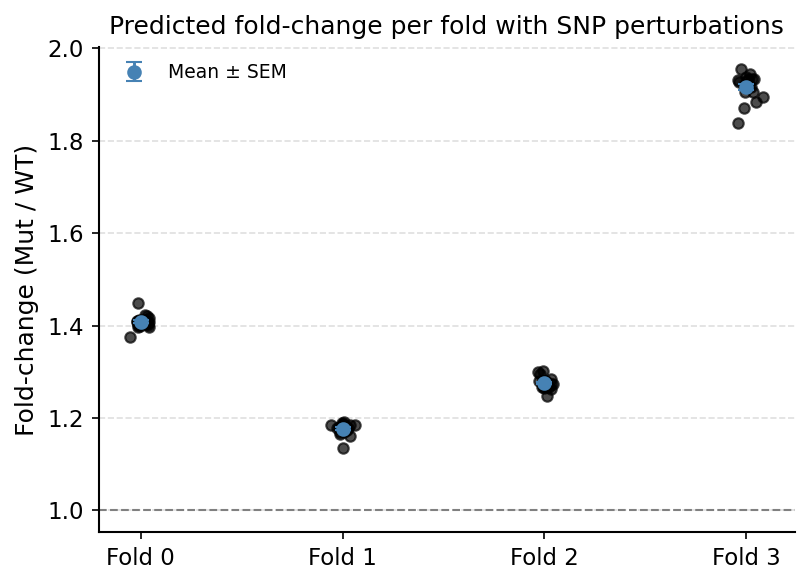

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- assuming df is loaded ---
df['fold'] = df['fold'].astype(int)

# compute simple fold change (Mut/WT, not log)
wt_mean = df[df['promoter'].str.endswith('WT')]['exp'].mean()
df['fold_change'] = df['exp'] / wt_mean

# focus on SNPs only
snp_df = df[df['promoter'].str.contains('SNP')]

# mean ± SEM per fold
snp_summary = (
    snp_df.groupby('fold', as_index=False)
    .agg(mean=('fold_change','mean'),
         std=('fold_change','std'),
         n=('fold_change','count'))
)
snp_summary['sem'] = snp_summary['std'] / np.sqrt(snp_summary['n'].clip(lower=1))

folds = sorted(snp_df['fold'].unique())
x = np.arange(len(folds)) * 0.6  # tighter spacing

fig, ax = plt.subplots(figsize=(5.5,4))

# individual SNPs
for i, f in enumerate(folds):
    vals = snp_df.loc[snp_df['fold']==f, 'fold_change']
    jitter = np.random.normal(0, 0.015, size=len(vals))
    ax.plot(np.full_like(vals, x[i]) + jitter, vals,
            'o', color='black', alpha=0.7, markersize=5, label='_nolegend_')

# mean ± SEM
ax.errorbar(x, snp_summary['mean'], yerr=snp_summary['sem'],
            fmt='o', color='steelblue', capsize=4, lw=1.4, label='Mean ± SEM')

# formatting
ax.axhline(1, linestyle='--', color='gray', lw=1)
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {f}' for f in folds])
ax.set_ylabel('Fold-change (Mut / WT)')
ax.set_title('Predicted fold-change per fold with SNP perturbations')
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.savefig('prac.svg', transparent=True)
plt.show()


In [280]:
import pandas as pd
import numpy as np

# --- example setup ---
# df columns expected: ['fold', 'promoter', 'exp']
# promoter includes 'MUT' and 'SNP' labels
df['fold'] = df['fold'].astype(int)

# 1️⃣ Compute mean expression per fold (model-level mean)
model_means = (
    df[df['promoter'].str.contains('MUT')]
    .groupby('fold')['exp']
    .mean())

# variance across folds = model variability
model_var = np.var(model_means, ddof=1)
model_sd = np.sqrt(model_var)

# 2️⃣ Compute SNP variance within each fold (biological variability)
snp_within = (
    df[df['promoter'].str.contains('SNP')]
    .groupby('fold')['exp']
    .var(ddof=1)
)

# mean within-fold SNP variance = biological variability
bio_var = np.nanmean(snp_within)
bio_sd = np.sqrt(bio_var)

# 3️⃣ Compare magnitudes
print(f"Model variability (across folds): SD = {model_sd:.3f}")
print(f"Biological background variability (within folds): SD = {bio_sd:.3f}")

# 4️⃣ Optionally compute their relative contribution
total_var = model_var + bio_var
model_frac = model_var / total_var if total_var > 0 else np.nan
bio_frac   = bio_var / total_var if total_var > 0 else np.nan

print(f"\nFraction of total variability:")
print(f"  • Model contribution: {100*model_frac:.1f}%")
print(f"  • Biological (SNP) contribution: {100*bio_frac:.1f}%")

Model variability (across folds): SD = 538.590
Biological background variability (within folds): SD = 29.246

Fraction of total variability:
  • Model contribution: 99.7%
  • Biological (SNP) contribution: 0.3%


In [281]:
import pandas as pd
import numpy as np

# df should have: ['fold', 'promoter', 'exp', 'delta']
# delta = expression change (Mut - WT) or log2(Mut / WT)

df['fold'] = df['fold'].astype(int)

# Option 1: if 'delta' already exists
vals = df[['fold', 'promoter', 'delta']].copy()

# Option 2: compute delta on the fly (if you have WT rows)
# wt_exp = df[df['promoter'].str.endswith('WT')].groupby('fold')['exp'].mean()
# vals = df.copy()
# vals['delta'] = vals.apply(lambda r: r['exp'] - wt_exp.loc[r['fold']], axis=1)

# Separate model-level deltas vs SNP deltas
mut_df = vals[vals['promoter'].str.endswith('MUT')]
snp_df = vals[vals['promoter'].str.contains('SNP')]

# 1️⃣ Model variability (between folds)
model_var = np.var(mut_df.groupby('fold')['delta'].mean(), ddof=1)
model_sd = np.sqrt(model_var)

# 2️⃣ Biological variability (within fold)
bio_within = snp_df.groupby('fold')['delta'].var(ddof=1)
bio_var = np.nanmean(bio_within)
bio_sd = np.sqrt(bio_var)

# 3️⃣ Relative contributions
total_var = model_var + bio_var
model_frac = model_var / total_var if total_var > 0 else np.nan
bio_frac   = bio_var / total_var if total_var > 0 else np.nan

print(f"Model variability (across folds): SD = {model_sd:.3f}")
print(f"Biological background variability (within folds): SD = {bio_sd:.3f}")
print(f"\nFraction of total variability:")
print(f"  • Model: {100*model_frac:.1f}%")
print(f"  • Biological (SNP): {100*bio_frac:.1f}%")

Model variability (across folds): SD = 148.863
Biological background variability (within folds): SD = 29.246

Fraction of total variability:
  • Model: 96.3%
  • Biological (SNP): 3.7%


In [283]:
# normalized contributions
model_frac = model_var / total_var
bio_frac = bio_var / total_var

# overall prediction stability metric
stability_score = 1 / np.sqrt(total_var)   # smaller variance = higher stability
stability_score

0.006591563147747982

In [285]:
mean_delta = mut_df['delta'].mean()
sem_total = np.sqrt(total_var)
SNR = abs(mean_delta) / sem_total
SNR

4.834911568873145

In [299]:
abs(mean_delta)

733.5

In [289]:
SNR

4.834911568873145

Text(0.5, 1.0, 'Prediction stability across folds and SNPs')

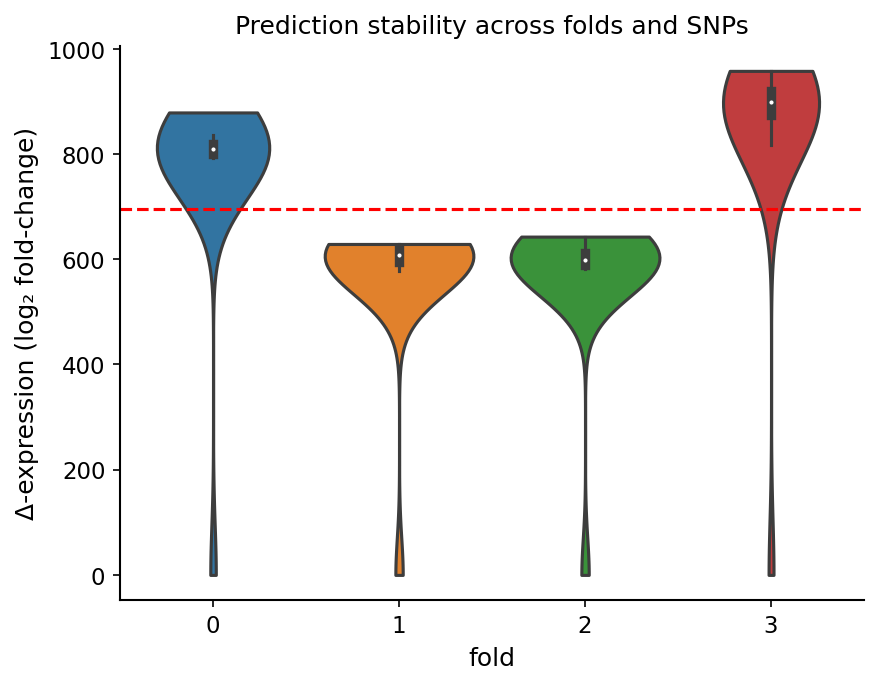

In [286]:
import seaborn as sns
sns.violinplot(data=df, x='fold', y='delta', inner='box', cut=0)
plt.axhline(df['delta'].mean(), color='red', linestyle='--')
plt.ylabel('Δ-expression (log₂ fold-change)')
plt.title('Prediction stability across folds and SNPs')


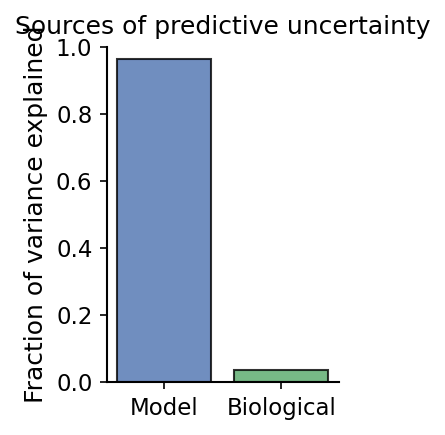

In [298]:
import matplotlib.pyplot as plt
import numpy as np

# compute fractions
total_var = model_var + bio_var
model_frac = model_var / total_var
bio_frac   = bio_var / total_var

plt.figure(figsize=(2.4,3))
plt.bar(['Model', 'Biological'],
        [model_frac, bio_frac],
        color=['#4C72B0','#55A868'],
        alpha=0.8, edgecolor='black')

plt.ylabel('Fraction of variance explained')
plt.ylim(0, 1)
plt.title('Sources of predictive uncertainty')
plt.tight_layout()
plt.savefig('prac.svg', transparent=True)
plt.show()


In [14]:
#Pass sequence
#============================
center_pos = 166148245
window = 
chrom = 'chr2'
start = center_pos - (seq_len // 2)
end = center_pos + (seq_len // 2)
poses = [int(curr_mut.split('-')[1])]
alts = [curr_mut.split('-')[-1]]


#Generate sequence
#===================
wt_code = process_sequence(fasta_open, chrom, start, end)

#single SNP within window - model sensitivity 
#================

poses = []


#use some multie SNP -> biological context + model

#generate n times

curr_seq = mutate(wt_code, poses, alts)
curr_seq = wt_code


#check


In [ ]:
# run n times on each

# visualise and get working

In [ ]:
import numpy as np
import pandas as pd

def process(models, wt_code, mut_code,
                                      window_start, window_end,
                                      gene_start, gene_end,
                                      channel_indices,
                                      channel_aggregate='mean',
                                      bin_normalize=False,
                                      reduce='sum',
                                      pseudocount=1e-6):
    """
    Returns:
      df: tidy per-fold dataframe (WT & MUT gene-level expr, delta, log2FC)
      tracks: dict with:
        x            (Nbins,)
        wt_tracks    (F, Nbins)
        mut_tracks   (F, Nbins)
        resid_tracks (F, Nbins)  = mut - wt
        wt_mean, wt_sd           (Nbins,)
        mut_mean, mut_sd         (Nbins,)
        resid_mean, resid_sd     (Nbins,)
    Notes:
      - bin_normalize=False recommended for expression deltas/log2FC.
      - region used for tracks is the gene span [min(gene_start, gene_end), max(...)].
    """
    # region (ascending coords)
    region_start = min(gene_start, gene_end)
    region_end   = max(gene_start, gene_end)

    # to collect fold-level tracks & scalars
    wt_tracks, mut_tracks, resid_tracks = [], [], []
    records = []

    x_ref = None  # will capture bin centers once

    for fold_ix, mdl in enumerate(models):
        # per-fold predictions (IMPORTANT: wrap single model)
        y_wt_f  = predict_tracks([mdl], wt_code)  # (1,1,B,T)
        y_mut_f = predict_tracks([mdl], mut_code)

        # --- aggregate channels & slice region (returns x_reg, t_reg) ---
        x_wt, t_wt = aggregate_region(y_wt_f,  window_start, window_end,
                                      region_start, region_end,
                                      channel_indices, aggregate=channel_aggregate,
                                      normalize_counts=bin_normalize)
        x_mut, t_mut = aggregate_region(y_mut_f, window_start, window_end,
                                        region_start, region_end,
                                        channel_indices, aggregate=channel_aggregate,
                                        normalize_counts=bin_normalize)

        if x_ref is None:
            x_ref = x_wt
        else:
            # sanity: region binning should match across folds
            assert np.allclose(x_ref, x_wt), "Inconsistent x bins across folds"

        # gene-level scalars
        expr_wt  = gene_expression_from_bins(x_wt,  t_wt,  gene_start, gene_end, reduce=reduce)
        expr_mut = gene_expression_from_bins(x_mut, t_mut, gene_start, gene_end, reduce=reduce)
        delta    = expr_mut - expr_wt
        log2fc   = np.log2((expr_mut + pseudocount) / (expr_wt + pseudocount))

        # store tracks
        wt_tracks.append(t_wt)
        mut_tracks.append(t_mut)
        resid_tracks.append(t_mut - t_wt)

        # store rows
        records.append({'fold': fold_ix, 'condition': 'WT',
                        'expr': expr_wt, 'delta_vs_WT': 0.0, 'log2FC_vs_WT': 0.0})
        records.append({'fold': fold_ix, 'condition': 'MUT',
                        'expr': expr_mut, 'delta_vs_WT': delta, 'log2FC_vs_WT': log2fc})

    # stack tracks: (F, Nbins)
    wt_arr    = np.stack(wt_tracks, axis=0)
    mut_arr   = np.stack(mut_tracks, axis=0)
    resid_arr = np.stack(resid_tracks, axis=0)

    # fold means / sds (per bin)
    wt_mean, wt_sd         = wt_arr.mean(0), wt_arr.std(0)
    mut_mean, mut_sd       = mut_arr.mean(0), mut_arr.std(0)
    resid_mean, resid_sd   = resid_arr.mean(0), resid_arr.std(0)

    # assemble dataframe
    df = pd.DataFrame.from_records(records)

    tracks = dict(
        x=x_ref,
        wt_tracks=wt_arr, mut_tracks=mut_arr, resid_tracks=resid_arr,
        wt_mean=wt_mean, wt_sd=wt_sd,
        mut_mean=mut_mean, mut_sd=mut_sd,
        resid_mean=resid_mean, resid_sd=resid_sd
    )
    return df, tracks


import matplotlib.pyplot as plt
import seaborn as sns

def plot_foldwise_expression(df, title="SCN1A predicted expression (brain tracks)"):
    """
    df: output from foldwise_expression_df
    """
    # Pivot for convenience: fold × condition → expr
    expr_wide = df.pivot(index='fold', columns='condition', values='expr')
    fold_means = expr_wide.mean()
    fold_sds   = expr_wide.std()

    plt.figure(figsize=(6,4))
    
    # plot per fold as paired dots + lines
    for fold, row in expr_wide.iterrows():
        plt.plot(['WT','MUT'], row.values, marker='o', linestyle='-', alpha=0.7, color='gray')

    # overlay mean ± sd
    plt.errorbar(['WT','MUT'], fold_means.values, yerr=fold_sds.values,
                 fmt='o', markersize=10, color='black', capsize=5, label='Mean ± SD')

    plt.ylabel("Predicted expression (sum of bins)")
    plt.title(title)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_foldwise_delta(df, title="Change in expression per fold"):
    """Plot bar chart of per-fold Δ and log2FC."""
    mut_rows = df[df['condition']=='MUT'].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    sns.barplot(x='fold', y='delta_vs_WT', data=mut_rows, ax=axes[0], color='tab:blue')
    axes[0].set_title("Δ (MUT − WT)")
    axes[0].axhline(0, color='k', linewidth=1)

    sns.barplot(x='fold', y='log2FC_vs_WT', data=mut_rows, ax=axes[1], color='tab:orange')
    axes[1].set_title("log2 Fold Change")
    axes[1].axhline(0, color='k', linewidth=1)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def aggregate_region(y, window_start, window_end,
                     region_start, region_end,
                     channel_indices, aggregate='mean',
                     normalize_counts=False):
    """y: (1,1,B,T). Returns x_reg (bin centers) and aggregated track in region."""
    _, _, B, T = y.shape
    y_bt = y[0,0]  # (B,T)
    if aggregate == 'mean':
        track = y_bt[:, channel_indices].mean(axis=1)
    elif aggregate == 'sum':
        track = y_bt[:, channel_indices].sum(axis=1)
    else:
        raise ValueError("aggregate must be 'mean' or 'sum'")
    bp_per_bin = (window_end - window_start) / float(B)
    x = window_start + bp_per_bin * (np.arange(B) + 0.5)
    mask = (x >= region_start) & (x <= region_end)
    x_reg = x[mask]
    t_reg = track[mask]
    if normalize_counts:
        t_reg = t_reg / (t_reg.sum() + 1e-8)
    return x_reg, t_reg

def gene_expression_from_bins(x, vals, gene_start, gene_end, reduce='sum'):
    lo, hi = min(gene_start, gene_end), max(gene_start, gene_end)
    m = (x >= lo) & (x <= hi)
    if reduce == 'sum':
        return float(vals[m].sum())
    elif reduce == 'mean':
        return float(vals[m].mean())
    else:
        raise ValueError("reduce must be 'sum' or 'mean'")

In [ ]:
#Pass current mutation
#============================
#use promoter ends as centre locations
prom = P1a
curr_mut = 'chr2-166148245-C-G'
center_pos = prom[0]
chrom = 'chr2'
start = center_pos - (seq_len // 2)
end = center_pos + (seq_len // 2)
poses = [int(curr_mut.split('-')[1])]
alts = [curr_mut.split('-')[-1]]


# Run across folds 
#====================
wt_code = process_sequence(fasta_open, chrom, start, end)
mut_code = mutate(wt_code, poses, alts)

df, tracks = process(
    models=models,
    wt_code=wt_code, mut_code=mut_code,
    window_start=start, window_end=start+seq_len,
    gene_start=scn1a[0], gene_end=scn1a[1],
    channel_indices=[17,18,19],           # your brain donors
    channel_aggregate='mean',
    bin_normalize=False,                   # keep magnitudes for delta/log2FC
    reduce='sum'
)
